## 0. Imports, Setup

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import from_json, col, explode
import numpy as np
import pandas as pd

Loading the table schema

In [0]:
%run "./pid_schema"

In [0]:
get_pid_schema()

Out[12]: StructType([StructField('geometry', StructType([StructField('coordinates', ArrayType(StringType(), True), True), StructField('type', StringType(), True)]), True), StructField('properties', StructType([StructField('last_position', StructType([StructField('bearing', IntegerType(), True), StructField('delay', StructType([StructField('actual', IntegerType(), True), StructField('last_stop_arrival', StringType(), True), StructField('last_stop_departure', StringType(), True)]), True), StructField('is_canceled', BooleanType(), True), StructField('last_stop', StructType([StructField('arrival_time', StringType(), True), StructField('departure_time', StringType(), True), StructField('id', StringType(), True), StructField('sequence', IntegerType(), True)]), True), StructField('next_stop', StructType([StructField('arrival_time', StringType(), True), StructField('departure_time', StringType(), True), StructField('id', StringType(), True), StructField('sequence', IntegerType(), True)]), True

**Read from the stream, create table**

In [0]:
JAAS = 'org.apache.kafka.common.security.scram.ScramLoginModule required username="fel.student" password="FelBigDataWinter2022bflmpsvz";'

df_buses = spark.readStream \
  .format("kafka")\
  .option("kafka.bootstrap.servers", "b-2-public.bdffelkafka.3jtrac.c19.kafka.us-east-1.amazonaws.com:9196, b-1-public.bdffelkafka.3jtrac.c19.kafka.us-east-1.amazonaws.com:9196") \
  .option("kafka.sasl.mechanism", "SCRAM-SHA-512")\
  .option("kafka.security.protocol", "SASL_SSL") \
  .option("kafka.sasl.jaas.config", JAAS) \
  .option("subscribe", "buses") \
  .load()

schema_pid = get_pid_schema() 
base_buses = df_buses.select(from_json(col("value").cast("string"),schema_pid).alias("data")).select("data.*")

In [0]:
select_stream = base_buses.writeStream \
        .format("memory")\
        .queryName("mem_buses")\
        .outputMode("append")\
        .start()

In [0]:
JAAS = 'org.apache.kafka.common.security.scram.ScramLoginModule required username="fel.student" password="FelBigDataWinter2022bflmpsvz";'

df_regbuses = spark.readStream \
  .format("kafka")\
  .option("kafka.bootstrap.servers", "b-2-public.bdffelkafka.3jtrac.c19.kafka.us-east-1.amazonaws.com:9196, b-1-public.bdffelkafka.3jtrac.c19.kafka.us-east-1.amazonaws.com:9196") \
  .option("kafka.sasl.mechanism", "SCRAM-SHA-512")\
  .option("kafka.security.protocol", "SASL_SSL") \
  .option("kafka.sasl.jaas.config", JAAS) \
  .option("subscribe", "regbuses") \
  .load()

schema_pid = get_pid_schema() 
base_regbuses = df_regbuses.select(from_json(col("value").cast("string"),schema_pid).alias("data")).select("data.*")

select_stream_reg = base_regbuses.writeStream \
        .format("memory")\
        .queryName("mem_regbuses")\
        .outputMode("append")\
        .start()

How many rows are in the stream at the moment?

In [0]:
%sql
select (*) from mem_buses limit 3;

geometry,properties,type
"List(List(14.43639, 50.07817), Point)","List(List(204, List(-17, null, 54), null, List(2023-02-15T16:38:00+01:00, 2023-02-15T16:38:00+01:00, U427Z1P, 4), List(2023-02-15T16:41:00+01:00, 2023-02-15T16:41:00+01:00, U1062Z1P, 5), 2023-02-15T16:39:38+01:00, 2.048, null, on_track, true), List(List(DP PRAHA, DP PRAHA), List(null, null), List(L135, 135, 3, Chodov, 135_31_221227, null), 135, 3, 2023-02-15T16:32:00+01:00, 6729, List(autobus, bus, 3), true, null))",Feature
"List(List(14.42472, 50.04363), Point)","List(List(107, List(35, null, 35), null, List(2023-02-15T16:39:00+01:00, 2023-02-15T16:39:00+01:00, U569Z2P, 6), List(2023-02-15T16:40:00+01:00, 2023-02-15T16:40:00+01:00, U495Z2P, 7), 2023-02-15T16:39:35+01:00, 5.212, null, on_track, true), List(List(DP PRAHA, DP PRAHA), List(null, null), List(L118, 118, 3, Sídliště Spořilov, 118_166_230103, null), 118, 10, 2023-02-15T16:29:00+01:00, 6895, List(autobus, bus, 3), true, null))",Feature
"List(List(14.57705, 50.10866), Point)","List(List(260, List(2, null, null), null, List(2023-02-15T16:40:00+01:00, 2023-02-15T16:40:00+01:00, U897Z7P, 10), List(2023-02-15T16:42:00+01:00, 2023-02-15T16:42:00+01:00, U1129Z2P, 11), 2023-02-15T16:40:02+01:00, 5.949, null, at_stop, true), List(List(DP PRAHA, DP PRAHA), List(null, null), List(L141, 141, 3, Bazén Hloubětín, 141_16_220901, null), 141, 1, 2023-02-15T16:26:00+01:00, 3564, List(autobus, bus, 3), true, null))",Feature


In [0]:
%sql
select count(*) from mem_regbuses

count(1)
14028


In [0]:
%sql
drop table data_buses;
drop table data_regbuses

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-2101734546930670> in <cell line: 1>()
      6     display(df)
      7     return df
----> 8   _sqldf = ____databricks_percent_sql()
      9 finally:
     10   del ____databricks_percent_sql

<command-2101734546930670> in ____databricks_percent_sql()
      3     import base64
      4     spark.sql(base64.standard_b64decode("ZHJvcCB0YWJsZSBkYXRhX2J1c2Vz").decode())
----> 5     df = spark.sql(base64.standard_b64decode("ZHJvcCB0YWJsZSBkYXRhX3JlZ2J1c2Vz").decode())
      6     display(df)
      7     return df

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49                 logger.log_success(
     50                     module_name, class_name, function_name, time

Create from bus stream

In [0]:
%sql
create table data_buses select * from mem_buses;
create table data_regbuses select * from mem_regbuses;

---------------------------------------------------------------------------
AnalysisException                         Traceback (most recent call last)
<command-1770401189163618> in <cell line: 1>()
      6     display(df)
      7     return df
----> 8   _sqldf = ____databricks_percent_sql()
      9 finally:
     10   del ____databricks_percent_sql

<command-1770401189163618> in ____databricks_percent_sql()
      2   def ____databricks_percent_sql():
      3     import base64
----> 4     spark.sql(base64.standard_b64decode("Y3JlYXRlIHRhYmxlIGRhdGFfYnVzZXMgc2VsZWN0ICogZnJvbSBtZW1fYnVzZXM=").decode())
      5     df = spark.sql(base64.standard_b64decode("Y3JlYXRlIHRhYmxlIGRhdGFfcmVnYnVzZXMgc2VsZWN0ICogZnJvbSBtZW1fcmVnYnVzZXM=").decode())
      6     display(df)

/databricks/spark/python/pyspark/instrumentation_utils.py in wrapper(*args, **kwargs)
     46             start = time.perf_counter()
     47             try:
---> 48                 res = func(*args, **kwargs)
     49           

# Detection of the bus behind
## 1. Creating table for queries
Firstly, let's make a new table with data needed for the detection:
- Arrival and departure time of buses
- delay of buses
- bus id and number (`short_route_name`) 
- type of vehicle (regional/regular bus)
- bus registration number
- id and name of the station 

We use data about the last stop, from topics: buses and regional buses.

In [0]:
%sql
drop table buses_city;
drop table buses_reg;

In [0]:
%sql 
create table buses_city
  select properties.trip.gtfs.route_id as bus_id,
         properties.trip.gtfs.route_short_name as bus_number, 
         properties.trip.vehicle_registration_number as bus_registr_num,
         properties.trip.vehicle_type.description_en as bus,
         properties.last_position.last_stop.id as last_stop_id,
         properties.last_position.next_stop.id as next_stop_id,
         properties.trip.gtfs.trip_id as trip_id,
         properties.last_position.state_position as bus_state,
         properties.last_position.delay.actual as delay, 
         properties.last_position.origin_timestamp as current_time,
         properties.last_position.last_stop.arrival_time as schedule_last_stop_arrival, 
         properties.last_position.last_stop.departure_time as schedule_last_stop_departure,
         properties.last_position.next_stop.arrival_time as schedule_next_stop_arrival, 
         properties.last_position.next_stop.departure_time as schedule_next_stop_departure,
         geometry as bus_geo
  from data_buses;
  
create table buses_reg
  select properties.trip.gtfs.route_id as regbus_id,
         properties.trip.gtfs.route_short_name as regbus_number, 
         properties.trip.vehicle_registration_number as regbus_registr_num,
         properties.trip.vehicle_type.description_en as regbus,
         properties.last_position.last_stop.id as regbus_stop_id,
         properties.last_position.last_stop.arrival_time as regbus_arrival_time, 
         properties.last_position.last_stop.departure_time as regbus_departure_time,
         properties.last_position.delay.actual as regbus_delay, 
         geometry as regbus_geo
  from data_regbuses


num_affected_rows,num_inserted_rows


In [0]:
%sql
select * from buses_city limit 5;

bus_id,bus_number,bus_registr_num,bus,last_stop_id,next_stop_id,trip_id,bus_state,delay,current_time,schedule_last_stop_arrival,schedule_last_stop_departure,schedule_next_stop_arrival,schedule_next_stop_departure,bus_geo
L135,135,6729,bus,U427Z1P,U1062Z1P,135_31_221227,on_track,-17,2023-02-15T16:39:38+01:00,2023-02-15T16:38:00+01:00,2023-02-15T16:38:00+01:00,2023-02-15T16:41:00+01:00,2023-02-15T16:41:00+01:00,"List(List(14.43639, 50.07817), Point)"
L118,118,6895,bus,U569Z2P,U495Z2P,118_166_230103,on_track,35,2023-02-15T16:39:35+01:00,2023-02-15T16:39:00+01:00,2023-02-15T16:39:00+01:00,2023-02-15T16:40:00+01:00,2023-02-15T16:40:00+01:00,"List(List(14.42472, 50.04363), Point)"
L141,141,3564,bus,U897Z7P,U1129Z2P,141_16_220901,at_stop,2,2023-02-15T16:40:02+01:00,2023-02-15T16:40:00+01:00,2023-02-15T16:40:00+01:00,2023-02-15T16:42:00+01:00,2023-02-15T16:42:00+01:00,"List(List(14.57705, 50.10866), Point)"
L225,225,4005,bus,U587Z1P,U1114Z1P,225_2367_230201,on_track,226,2023-02-15T16:39:46+01:00,2023-02-15T16:36:00+01:00,2023-02-15T16:36:00+01:00,2023-02-15T16:37:00+01:00,2023-02-15T16:37:00+01:00,"List(List(14.33551, 50.03714), Point)"
L140,140,6886,bus,U766Z1P,U368Z1P,140_1869_221227,on_track,-11,2023-02-15T16:39:15+01:00,2023-02-15T16:38:00+01:00,2023-02-15T16:38:00+01:00,2023-02-15T16:40:00+01:00,2023-02-15T16:40:00+01:00,"List(List(14.50616, 50.14899), Point)"


In [0]:
%sql
select * from buses_reg limit 5;

regbus_id,regbus_number,regbus_registr_num,regbus,regbus_stop_id,regbus_arrival_time,regbus_departure_time,regbus_delay,regbus_geo
L356,356,8888,regional bus,U1212Z1,2023-02-16T11:00:00+01:00,2023-02-16T11:00:00+01:00,-46,"List(List(14.32326, 50.14365), Point)"
L322,322,8762,regional bus,U4799Z2,2023-02-16T10:59:00+01:00,2023-02-16T10:59:00+01:00,24,"List(List(14.07915, 50.19043), Point)"
L311,311,9809,regional bus,U1601Z1,2023-02-16T10:58:00+01:00,2023-02-16T10:58:00+01:00,53,"List(List(14.24998, 49.9202), Point)"
L368,368,8061,regional bus,U651Z5,2023-02-16T10:58:00+01:00,2023-02-16T10:58:00+01:00,58,"List(List(14.47841, 50.13331), Point)"
L754,754,9710,regional bus,U4533Z1,2023-02-16T10:48:00+01:00,2023-02-16T10:48:00+01:00,356,"List(List(14.48893, 49.73206), Point)"


Some data analysis:
- Does arrival_time and departure_time differ? -> YES, as expected

In [0]:
%sql
select regbus_number, regbus_stop_id, regbus_arrival_time, regbus_departure_time, regbus_delay
from buses_reg
where regbus_arrival_time <> regbus_departure_time

regbus_number,regbus_stop_id,regbus_arrival_time,regbus_departure_time,regbus_delay
637,U2848Z6,2023-02-16T10:55:00+01:00,2023-02-16T11:04:00+01:00,-327
646,U4366Z1,2023-02-16T10:53:00+01:00,2023-02-16T10:54:00+01:00,255
332,U2109Z2,2023-02-16T10:57:00+01:00,2023-02-16T11:00:00+01:00,0
322,U4314Z3,2023-02-16T10:58:00+01:00,2023-02-16T11:02:00+01:00,-187
399,U1915Z2,2023-02-16T10:59:00+01:00,2023-02-16T11:00:00+01:00,-71
401,U6489Z4,2023-02-16T10:54:00+01:00,2023-02-16T10:55:00+01:00,241
426,U1450Z1,2023-02-16T10:42:00+01:00,2023-02-16T11:01:00+01:00,0
720,U2987Z11,2023-02-16T10:52:00+01:00,2023-02-16T10:55:00+01:00,71
345,U2987Z7,2023-02-16T10:42:00+01:00,2023-02-16T10:45:00+01:00,866
637,U2848Z6,2023-02-16T10:55:00+01:00,2023-02-16T11:04:00+01:00,-327


Join the tables - using inner join since we want to detect station where collisions happen

In [0]:
%sql
drop table buses;

In [0]:
%sql
create table buses 
  select * 
  from buses_city 
  inner join buses_reg on buses_city.last_stop_id = buses_reg.regbus_stop_id 

num_affected_rows,num_inserted_rows


In [0]:
%sql
select count(*) from buses;

count(1)
0


**Looks like there are no common stations so we continue only with topic of buses.**

## 2. Detect buses, which may occur on one bus stop at the same time

* Collision happens when the first bus is on the bus stop and the following buses have time gap only 3 minutes or lower
* Collect places, where this happens, type of vehicle and short route name.
* Find top 10 collision places

#### Detect event when any bus catches previous one at a specific stop:
##### 1. Get buses which are currently at a bus stop
- `last_stop_id` = specific stop
- first bus is on the bus stop - `bus_state = "at bus"`
- get the time it is expected to depart from a station (with current delay): `current_time`

In [0]:
%sql
drop table first_buses

In [0]:
%sql
create table first_buses
  select bus_number, bus_registr_num, trip_id, last_stop_id, delay, cast(current_time as timestamp) as expected_departure1, bus_state
  from buses_city
  where bus_state = "at_stop"

num_affected_rows,num_inserted_rows


In [0]:
%sql
select * from first_buses limit 5;

bus_number,bus_registr_num,trip_id,last_stop_id,delay,expected_departure1,bus_state
141,3564,141_16_220901,U897Z7P,2,2023-02-15T15:40:02.000+0000,at_stop
188,5033,188_33_221227,U559Z2P,6,2023-02-15T15:40:06.000+0000,at_stop
133,3750,133_3299_221227,U767Z1P,245,2023-02-15T15:40:05.000+0000,at_stop
259,3565,259_2_220901,U1228Z2P,2105,2023-02-15T15:40:05.000+0000,at_stop
118,6724,118_154_230103,U110Z8P,46,2023-02-15T15:39:46.000+0000,at_stop


##### 2. Get following buses
- `next_stop_id` = specific stop
- select arbirtrary `bus_state` (it can still be at a previous station or on the way to a current station)
- get the expected time to arrive to the next station as `schedule_next_stop_departure` + `delay`

In [0]:
%sql
drop table following_buses

In [0]:
%sql
create table following_buses
  select bus_number, bus_registr_num, trip_id, next_stop_id, delay, bus_state,
    cast(current_time as timestamp), 
    cast(schedule_next_stop_departure as timestamp), 
    dateadd(second, delay, cast(schedule_next_stop_departure as timestamp)) as expected_departure2
  from buses_city

num_affected_rows,num_inserted_rows


In [0]:
%sql
select * from following_buses limit 5;

bus_number,bus_registr_num,trip_id,next_stop_id,delay,bus_state,current_time,schedule_next_stop_departure,expected_departure2
135,6729,135_31_221227,U1062Z1P,-17,on_track,2023-02-15T15:39:38.000+0000,2023-02-15T15:41:00.000+0000,2023-02-15T15:40:43.000+0000
118,6895,118_166_230103,U495Z2P,35,on_track,2023-02-15T15:39:35.000+0000,2023-02-15T15:40:00.000+0000,2023-02-15T15:40:35.000+0000
141,3564,141_16_220901,U1129Z2P,2,at_stop,2023-02-15T15:40:02.000+0000,2023-02-15T15:42:00.000+0000,2023-02-15T15:42:02.000+0000
225,4005,225_2367_230201,U1114Z1P,226,on_track,2023-02-15T15:39:46.000+0000,2023-02-15T15:37:00.000+0000,2023-02-15T15:40:46.000+0000
140,6886,140_1869_221227,U368Z1P,-11,on_track,2023-02-15T15:39:15.000+0000,2023-02-15T15:40:00.000+0000,2023-02-15T15:39:49.000+0000


##### 3. Find collisions within same bus lines
* Collision happens when the first bus is on a bus stop and the following buses have time gap only 3 minutes or lower:
`abs(expected_time1 - expected_time2) <= 3 minutes`
- (absolute values because we are insterested in both situations)
* Collect places, where this happens, type of vehicle and short route name.
* **Show collisions withing the same bus line only** (I understood this is the task from assignment)

In [0]:
%sql
drop table collisions

In [0]:
%sql
create table collisions
  select  bus_number1 as bus_number, bus_registr_num1, bus_registr_num2, stop_id1 as stop_id, expected_departure1, expected_departure2, 
    timestampdiff(second, expected_departure1, expected_departure2) as diff_seconds
  from
    (select bus_number as bus_number1, bus_registr_num as bus_registr_num1, last_stop_id as stop_id1, expected_departure1 from first_buses)
    inner join 
    (select bus_number as bus_number2, bus_registr_num as bus_registr_num2, next_stop_id as stop_id2, expected_departure2 from following_buses)
    on stop_id1=stop_id2 and bus_number1=bus_number2
  where timestampdiff(second, expected_departure1, expected_departure2) between -3 * 60 and 3 * 60 

num_affected_rows,num_inserted_rows


In [0]:
%sql
select * from collisions limit 5;

bus_number,bus_registr_num1,bus_registr_num2,stop_id,expected_departure1,expected_departure2,diff_seconds
135,6729,6729,U1062Z1P,2023-02-15T15:40:38.000+0000,2023-02-15T15:40:43.000+0000,5
177,6772,6772,U474Z4P,2023-02-15T15:42:05.000+0000,2023-02-15T15:41:53.000+0000,-12
133,3750,3750,U418Z1P,2023-02-15T15:42:05.000+0000,2023-02-15T15:42:05.000+0000,0
106,3727,3727,U488Z2P,2023-02-15T15:41:05.000+0000,2023-02-15T15:41:22.000+0000,17
182,3685,3685,U474Z5P,2023-02-15T15:42:02.000+0000,2023-02-15T15:42:06.000+0000,4


##### 4. Find top 10 collision places

In [0]:
%sql
drop table top_collision_places;

In [0]:
%sql
create table top_collision_places
  select stop_id, count(stop_id) as collision_count
  from collisions
  group by stop_id
  sort by count(stop_id) desc
  limit 10

num_affected_rows,num_inserted_rows


## 3. Load stop names 
* from file stops.json obtained from pid website
* make a new table with the stop names

In [0]:
df_stops = spark.read\
        .option("multiline","true")\
        .option("inferSchema", "true")\
        .json("/FileStore/tables/stops_pid.json")

# Get rid of the nested arrays
stop_names = df_stops.select('stopGroups.fullName').collect()[0][0]
station_ids = df_stops.select('stopGroups.stops.gtfsIds').collect()[0][0]
station_ids = [[i[0] for i in lli] for lli in station_ids]
len(stop_names), len(station_ids)

Out[444]: (7813, 7813)

In [0]:
%sql 
drop table stops_names_table

In [0]:
datadf = [[name, id] for name, id in zip(stop_names, station_ids)]
columns = ["stop_name", "station_id"]
df_stops = spark.createDataFrame(data = datadf, schema = columns)
df_stops = df_stops.withColumn("station_id", explode("station_id"))
df_stops.show(5)

+----------+----------+
| stop_name|station_id|
+----------+----------+
|    Adamov|   U7288Z1|
|  Albertov|   U876Z1P|
|  Albertov|   U876Z2P|
|  Albertov|   U876Z4P|
|Ametystová|  U1274Z1P|
+----------+----------+
only showing top 5 rows



In [0]:
df_stops.createOrReplaceTempView("stops_names_table")

In [0]:
%sql
create or replace table top_collision_places
select stop_id, stop_name, collision_count
from top_collision_places inner join stops_names_table on top_collision_places.stop_id=stops_names_table.station_id 

num_affected_rows,num_inserted_rows


## Top 10 collision stops with names:

In [0]:
%sql
select * from top_collision_places

stop_id,stop_name,collision_count
U897Z1P,Černý Most,541
U286Z5P,Háje,335
U151Z2P,Horčičkova,600
U181Z1P,Chodovec,437
U188Z1P,Chvaly,701
U335Z2P,Libuš,398
U337Z4P,Lihovar,652
U448Z1P,Nádraží Běchovice,421
U628Z1P,Terminál 1,447
U474Z6P,Vysočanská,344


## 4. Create dashboard
Create table for coordinates in order to visualize the dashboard

In [0]:
%sql
select stop_id from top_collision_places

stop_id
U897Z1P
U286Z5P
U151Z2P
U181Z1P
U188Z1P
U335Z2P
U337Z4P
U448Z1P
U628Z1P
U474Z6P


This is not optimal, did not have more time to fix it. It should draw only 10 places..

In [0]:
%sql
DROP table df_geo_table

In [0]:
%sql
CREATE table df_geo_table
  SELECT 
    cast(buses_city.bus_geo.coordinates[0] as double) AS x,
    cast(buses_city.bus_geo.coordinates[1] as double) AS y
  FROM top_collision_places
  INNER JOIN buses_city on top_collision_places.stop_id=buses_city.last_stop_id;

num_affected_rows,num_inserted_rows


In [0]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt

custom_filter='["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|road|road_link"]' 
G = ox.graph_from_place("Praha, Czechia", custom_filter=custom_filter) 

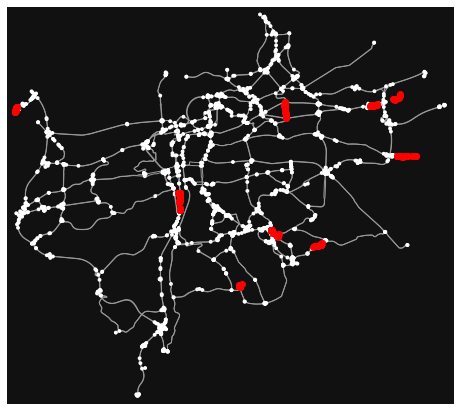

In [0]:
fig, ax = ox.plot_graph(G, show=False, close=False) 
df_geo = spark.sql("SELECT * FROM df_geo_table")
df_geo_p = df_geo.toPandas() 
x = df_geo_p.loc[1:300,'x'] 
y = df_geo_p.loc[1:300,'y'] 
ax.scatter(x, y, c='red') 
plt.show()

## and that's it. Thank you for reading.